# osm_LoD1_3DCityModel Walkthrough

**The purpose of this notebook is to prevent an excessive burden on the [OpenStreetMap](https://www.openstreetmap.org/about) server when [osm_LoD1_3DCityModel](https://github.com/AdrianKriger/osm_LoD1_3DCityModel/tree/main/village_campus) fails; and an investigation into *where* the challenge lies is needed.**

It saves the `overpass`.geojson to prevent calling OSM after every failure. Peruse `matplotlib` figure at you leisure. 

In [1]:
import warnings

import os
from itertools import chain#, izip

import requests
import overpass
import osm2geojson

import numpy as np
import pandas as pd
import geopandas as gpd
import topojson as tp

import shapely
import shapely.geometry as sg
from shapely.geometry import Point, LineString, Polygon, MultiPolygon, LinearRing, shape, mapping
from shapely.ops import snap
from shapely.ops import transform

import fiona
import copy
import json
import geojson

import pyproj

from openlocationcode import openlocationcode as olc

from cjio import cityjson

from osgeo import gdal, ogr, osr

import triangle as tr

import matplotlib.pyplot as plt

In [2]:
import time
from datetime import timedelta

**A `parameter.json` defines the path and files**.

In [5]:
jparams = json.load(open('osm3DtestUEstate_param.json'))
#jparams = json.load(open('osm3DtestCPUT_param.json'))

**First get everything via `overpass`**

In [6]:
#buildings
query = """
    [out:json][timeout:25];
    area[name='{0}'] ->.b;
    // -- target area ~ can be way or relation
    {1}(area.b)[name='{2}'];
    map_to_area -> .a;
        // I want all buildings ~ with levels tagged
        (way['building'](area.a);
        // and relation type=multipolygon ~ to removed courtyards from buildings
        relation['building']["type"="multipolygon"](area.a);
    );
    out body;
    >;
    out skel qt;
    """.format(jparams['LargeArea'], jparams['osm_type'], jparams['FocusArea'])
    
url = "http://overpass-api.de/api/interpreter"
r = requests.get(url, params={'data': query})
gj = osm2geojson.json2geojson(r.json())

#-- store the data as GeoJSON
with open(jparams['ori-gjson_out'], 'w') as outfile:                   
    json.dump(gj, outfile)

In [7]:
#project blds ~~ # set the path and dstSRS
ds = gdal.VectorTranslate(jparams['gjson-proj_out'], jparams['ori-gjson_out'], 
                          format = 'GeoJSON', reproject = True,# makeValid=True,
                          srcSRS='EPSG:4326', dstSRS=jparams['crs'])
    # de-reference and close dataset
del ds

In [8]:
#aoi
query = """
    [out:json][timeout:30];
    // main area
    area[name='{0}']->.a;
    //gather results
    (
    // focus
    {1}['name'='{2}'](area.a);
    );
    //print results
    out body;
    >;
    out skel qt;
    """.format(jparams['LargeArea'], jparams['osm_type'], jparams['FocusArea'])
    
url = "http://overpass-api.de/api/interpreter"
r = requests.get(url, params={'data': query})
area = osm2geojson.json2geojson(r.json())

#-- store the data as GeoJSON
with open(jparams['aoi'], 'w') as outfile:                  # set the path
    json.dump(area, outfile)

In [9]:
#project aoi ~~ # set the path and dstSRS
ds = gdal.VectorTranslate(jparams['aoi_prj'], jparams['aoi'], 
                          format = 'GeoJSON', reproject = True, makeValid=True,
                          srcSRS='EPSG:4326', dstSRS=jparams['crs'])
    # de-reference and close dataset
del ds

**Now we process.**  

**If you change the *geometry, shape or alignment* of a building in an [OSM editor](https://wiki.openstreetmap.org/wiki/Editors); call / retrieve only what you need; and continue.**

In [39]:
#process aoi 
aoi = gpd.read_file(jparams['aoi_prj'])                                                  # set the path
aoi.set_crs(epsg=int(jparams['crs'][-5:]), inplace=True, allow_override=True)            # set the crs
aoi.head(2)

,type,id,tags,geometry
0,relation,12622096,"{'name': 'University Estate', 'place': 'neighb...","MULTIPOLYGON (((264185.211 6241558.426, 264193..."


In [40]:
if jparams['osm_type'] == 'relation' and len(aoi) > 1:
    for i, row in aoi.iterrows():
        if row.tags != None and 'place' in row.tags:
            focus = row
            
    trim = pd.DataFrame(focus)
    trim = trim.T
    aoi = gpd.GeoDataFrame(trim, geometry = trim['geometry'])
    aoi = aoi.set_crs(jparams['crs'])

In [41]:
aoibuffer = aoi.copy()

def buffer01(row):
    return row.geometry.buffer(150, 
                               cap_style=3, join_style=2)

aoibuffer['geometry'] = aoibuffer.apply(buffer01, axis=1)
    
extent = [aoibuffer.total_bounds[0] - 250, aoibuffer.total_bounds[1] - 250, 
          aoibuffer.total_bounds[2] + 250, aoibuffer.total_bounds[3] + 250]

**Now the DEM**  
*two are available at [mwe](https://github.com/AdrianKriger/osm_LoD1_3DCityModel/tree/main/village_campus/mwe)*

In [42]:
gdal.SetConfigOption("GTIFF_SRS_SOURCE", "GEOKEYS")

# set the path and nodata
OutTile = gdal.Warp(jparams['projClip_raster'], 
                    jparams['in_raster'],
                    #-  srcSRS=prj,
                    dstSRS=jparams['crs'],
                    srcNodata = jparams['nodata'],
                    #-  dstNodata = 0,
                    #-- outputBounds=[minX, minY, maxX, maxY]
                    outputBounds = [extent[0], extent[1], extent[2], extent[3]])
OutTile = None 

In [43]:
# raster to xyz
xyz = gdal.Translate(jparams['xyz'], 
                     jparams['projClip_raster'],
                     format = 'XYZ')#, 
                     #noData = float(0))
xyz = None

**prepare to harvest elevation**

In [44]:
# set the path to the projected, cliped elevation
src_filename = jparams['projClip_raster']

src_ds = gdal.Open(src_filename) 
gt_forward = src_ds.GetGeoTransform()
rb = src_ds.GetRasterBand(1)

def rasterQuery(geom, gt_forward, rb):

    mx = geom.representative_point().x
    my = geom.representative_point().y
    
    px = int((mx - gt_forward[0]) / gt_forward[1])
    py = int((my - gt_forward[3]) / gt_forward[5])

    intval = rb.ReadAsArray(px, py, 1, 1)
 
    return intval[0][0]

**Buildings**

In [45]:
# set the path
ts = gpd.read_file(jparams['gjson-proj_out'])
ts['bld'] = ts['tags'].apply(lambda x: x.get('building'))
ts.drop(ts.index[ts['type'] == 'node'], inplace = True)

topo = tp.Topology(ts, prequantize=False, winding_order='CCW_CW')
ts = topo.toposimplify(0.2).to_gdf()

In [46]:
ts_copy = ts.copy()
new_df1 = ts_copy.loc[ts_copy.overlaps(ts_copy.unary_union)].reset_index(drop=True)  #-- perhaps no union?
ts_copy.drop(ts_copy.index[ts_copy['bld'] == 'bridge'], inplace = True)
ts_copy.drop(ts_copy.index[ts_copy['bld'] == 'roof'], inplace = True)

**Plot**

*Browse the saved `'./data/topologyFig'` at your leisure*

In [ ]:
#%matplotlib

fig, ax = plt.subplots(figsize=(11, 11))

ts_copy.plot(ax=ax, facecolor='none', edgecolor='purple', alpha=0.2)
if len(new_df1) > 0:
    new_df1.plot(ax=ax, edgecolor='red', facecolor='none')#, alpha=0.3)#, column='osm_building', legend=True)

#-- save
plt.savefig('./data/topologyFig', dpi=300)
#plt.show()

|  |  |
|:--------:|:--------:|
|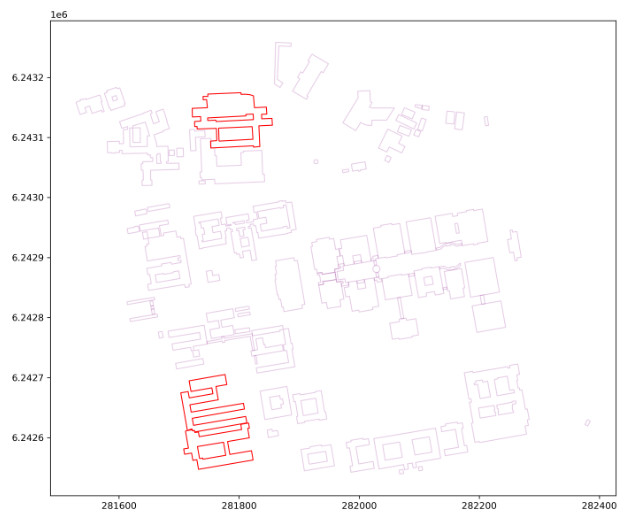 | **Challenges will be highlight in *Red*.**|
|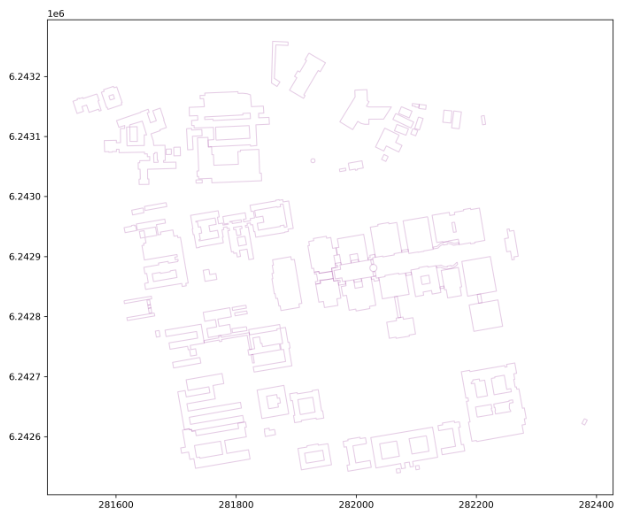 | **or none**|
|<br /> **If you continue without fixing the challenges, the LoD1 City Model *will not be error free*.** | <br /> **Our goal is a topologically correct surface.** |

<h2><center>Please ensure the quality of the value-added product and the source data.</center></h2>

**If necessary; edit [OpenStreetMap](https://www.openstreetmap.org/about) and fix the challenge please.**

<div class="alert alert-block alert-success"><b></b>
    
*And remember to give the OpenStreetMap server at **least a day** before attempting the process again.*  
*Alchemy is a process. **Please be patient**.*
</div>

In [ ]:
#- get the mean height of the bld
ts['mean'] = ts.apply(lambda row: rasterQuery(row.geometry, gt_forward, rb), axis = 1)
ts.head(2)

In [49]:
for i, row in ts.iterrows():
    if row.geometry.geom_type == 'LineString' and len(row.geometry.coords) < 3:
        ts = ts.drop(ts.index[i])

In [50]:
storeyheight = 2.8
    #-- iterate through the list of buildings and create GeoJSON features rich in attributes
footprints = {
    "type": "FeatureCollection",
    "features": []
}
for i, row in ts.iterrows():
    f = {
    "type" : "Feature"
    }
        # at a minimum we only want building:levels tagged
    if row['type'] != 'node' and row['tags'] != None and 'building:levels' in row['tags']:
        
        f["properties"] = {}
            
        #-- store all OSM attributes and prefix them with osm_ 
        f["properties"]["osm_id"] = row.id
        
        for p in row.tags:
            f["properties"]["osm_%s" % p] = row.tags[p]
            if row['bld'] != 'bridge' and row['bld'] != 'roof':
                adr = []
                #-- transform the OSM address to string prefix with osm_
                if 'addr:flats'in row.tags:
                    adr.append(row.tags['addr:flats'])
                if 'addr:housenumber'in row.tags:
                    adr.append(row.tags['addr:housenumber'])
                if 'addr:housename'in row.tags:
                    adr.append(row.tags['addr:housename'])
                if 'addr:street' in row.tags:
                    adr.append(row.tags['addr:street'])
                if 'addr:suburb' in row.tags:
                    adr.append(row.tags['addr:suburb'])
                if 'addr:postcode' in row.tags:
                    adr.append(row.tags['addr:postcode'])
                if 'addr:city' in row.tags:
                    adr.append(row.tags['addr:city'])
                if 'addr:province' in row.tags:
                    adr.append(row.tags['addr:province'])
                #-- store other OSM attributes and prefix them with osm_
  
            f["properties"]["osm_address"] = " ".join(adr)
                    
        osm_shape = shape(row["geometry"])
                #-- a few buildings are not polygons, rather linestrings. This converts them to polygons
                #-- rare, but if not done it breaks the code later
        if osm_shape.geom_type == 'LineString':
            osm_shape = Polygon(osm_shape)
                #-- and multipolygons must be accounted for
        elif osm_shape.geom_type == 'MultiPolygon':
                #osm_shape = Polygon(osm_shape[0])
            polys = list(osm_shape.geoms) 
            #for poly in list(osm_shape.geoms):
            for poly in polys:
                osm_shape = Polygon(poly)#[0])
                    #-- convert the shapely object to geojson
                           
        f["geometry"] = mapping(osm_shape)
        f["properties"]["footprint"] = mapping(osm_shape)
        
        if row['bld'] == 'bridge':
            f["properties"]['ground_height'] = round(row["mean"], 2)
            if row['tags']['min_height'] != None:
                f["properties"]['bottom_bridge_height'] = round(float(row.tags['min_height']) + row["mean"], 2)
            else:
                f["properties"]['bottom_bridge_height'] = round((float(row.tags['building:min_level']) * storeyheight) + row["mean"], 2)
            f["properties"]['building_height'] = round(float(row.tags['building:levels']) * storeyheight, 2)
            f["properties"]['roof_height'] = round(f["properties"]['building_height'] + row["mean"], 2)
        if row['bld'] == 'roof':
            f["properties"]['ground_height'] = round(row["mean"], 2)
            f["properties"]['bottom_roof_height'] = round(float(row.tags['building:levels']) * storeyheight + row["mean"], 2) 
            f["properties"]['roof_height'] = round(f["properties"]['bottom_roof_height'] + 1.5, 2)
        if row['bld'] != 'bridge' and row['bld'] != 'roof':
            f["properties"]['ground_height'] = round(row["mean"], 2)
            f["properties"]['building_height'] = round(float(row.tags['building:levels']) * storeyheight + 1.3, 2) 
            f["properties"]['roof_height'] = round(f["properties"]['building_height'] + row["mean"], 2)
            
            wgs84 = pyproj.CRS('EPSG:4326')
            utm = pyproj.CRS(jparams['crs'])                                   
            p = osm_shape.representative_point()
            project = pyproj.Transformer.from_crs(utm, wgs84, always_xy=True).transform
            wgs_point = transform(project, p)
            f["properties"]["plus_code"] = olc.encode(wgs_point.y, wgs_point.x, 11)

        footprints['features'].append(f)
            
for value in footprints['features']:
    if 'osm_addr:flats' in value["properties"]:
        del value["properties"]["osm_addr:flats"]
    if 'osm_addr:housenumber' in value["properties"]:
        del value["properties"]["osm_addr:housenumber"]
    if 'osm_addr:housename' in value["properties"]:
        del value["properties"]["osm_addr:housename"]
    if 'osm_addr:street' in value["properties"]:
        del value["properties"]["osm_addr:street"]
    if 'osm_addr:suburb' in value["properties"]:
        del value["properties"]["osm_addr:suburb"]
    if 'osm_addr:postcode' in value["properties"]:
        del value["properties"]["osm_addr:postcode"]
    if 'osm_addr:city' in value["properties"]:
        del value["properties"]["osm_addr:city"]
    if 'osm_addr:province' in value["properties"]:
        del value["properties"]["osm_addr:province"]

In [51]:
#-- store the data as GeoJSON
with open(jparams['osm_bldings'], 'w') as outfile:        # set the path
    json.dump(footprints, outfile)

In [52]:
from shapely.geometry import polygon
import math

start = time.time()

dis = gpd.read_file(jparams['osm_bldings'])                   
dis.set_crs(epsg=int(jparams['crs'][-5:]), inplace=True, allow_override=True)

dict_vertices = {}
cols = [c for c in ['bottom_bridge_height', 'bottom_roof_height', 'roof_height'] if c in dis.columns]

dis['geometry'] = dis.geometry.apply(polygon.orient, 1)

for i, row in dis.iterrows():
    oring = list(row.geometry.exterior.coords)
    name = row['osm_id']
    for (j, v) in enumerate(oring[:-1]):
        vertex = (oring[j][0], oring[j][1])
        attr = [row[c] for c in cols]
        attr = [x for x in attr if not np.isnan(x)]  # Remove np.nan values
        if vertex in dict_vertices.keys():
            dict_vertices[vertex][row['osm_id']] = attr
        else:
            dict_vertices[vertex] = {row['osm_id']: attr}

result = {}
for k1, d in dict_vertices.items():
    for k2 in d:
        result.setdefault(k2, {})[k1] = sorted(list(set([j for i in d.values() for j in i])))
        
dis.drop(dis.index[dis['osm_building'] == 'bridge'], inplace = True)
dis.drop(dis.index[dis['osm_building'] == 'roof'], inplace = True)

#- create a point representing the hole within each building  
dis['x'] = dis.representative_point().x
dis['y'] = dis.representative_point().y
hs = dis[['x', 'y', 'ground_height']].copy()

end = time.time()
print('runtime:', str(timedelta(seconds=(end - start))))

runtime: 0:00:00.093817


In [53]:
dis.head(2)

,osm_id,osm_address,osm_building,osm_building:levels,osm_name,osm_office,osm_operator,osm_type,osm_website,footprint,ground_height,building_height,roof_height,plus_code,geometry,x,y
0,739615941,10 Rhodes Avenue University Estate Cape Town,house,2,None,None,None,None,None,"{'type': 'Polygon', 'coordinates': [[[264275.9...",96.75,6.9,103.65,4FRW3C6X+WRG,"POLYGON ((264275.999 6241813.835, 264278.104 6...",264273.719480,6.241822e+06
1,740820432,100 Upper Roodebloem Road University Estate Ca...,house,2,None,None,None,None,None,"{'type': 'Polygon', 'coordinates': [[[264380.2...",85.37,6.9,92.27,4FRW3F62+R87,"POLYGON ((264380.263 6241798.225, 264379.703 6...",264385.690928,6.241794e+06


**Now we get into the *real stuff***

In [54]:
#- 
dis_c = dis.copy()

In [55]:
start = time.time()

df = pd.read_csv(jparams['xyz'],                                      
                 delimiter = ' ', header=None, names=["x", "y", "z"])
    
geometry = [Point(xy) for xy in zip(df.x, df.y)]
gdf = gpd.GeoDataFrame(df, crs=jparams['crs'], geometry=geometry)                    
    
_symdiff = gpd.overlay(aoibuffer, dis_c, keep_geom_type=False, how='symmetric_difference') 
_mask = gdf.within(_symdiff.loc[0, 'geometry'])
gdf = gdf.loc[_mask]
gdf = gdf[gdf['z'] != jparams['nodata']]                              
gdf.reset_index(drop=True, inplace=True)
gdf = gdf.round(2)

end = time.time()
print('runtime:', str(timedelta(seconds=(end - start))))

runtime: 0:00:02.811645


**segments**

In [56]:
#- blds
start = time.time()

all_coords = []
min_zbld = []
dps = 3
segs = set()

dis['geometry'] = dis.geometry.apply(polygon.orient, 1)

def rasterQuery2(mx, my, gt_forward, rb):
    
    px = int((mx - gt_forward[0]) / gt_forward[1])
    py = int((my - gt_forward[3]) / gt_forward[5])

    intval = rb.ReadAsArray(px, py, 1, 1)

    return intval[0][0]

for ids, row in dis.iterrows():
    oring = list(row.geometry.exterior.coords)
    coords_rounded = [(round(x, dps), round(y, dps), round(float(rasterQuery2(x, y, gt_forward, rb)), 2)) for x, y in oring]
    all_coords.extend(coords_rounded)
    zbld = [z for x, y, z in coords_rounded]
    min_zbld.append(min(zbld))
    
    segs.update({(x1, y1, x2, y2) if (x1 < x2) else (x2, y2, x1, y1) for (x1, y1, z1), (x2, y2, z2) in zip(coords_rounded[:-1], coords_rounded[1:])})
    
    for interior in row.geometry.interiors:
        oring = list(interior.coords)
        coords_rounded = [(round(x, dps), round(y, dps), round(float(rasterQuery2(x, y, gt_forward, rb)), 2)) for x, y in oring]
        all_coords.extend(coords_rounded)
        
        segs.update({(x1, y1, x2, y2) if (x1 < x2) else (x2, y2, x1, y1) for (x1, y1, z1), (x2, y2, z2) in zip(coords_rounded[:-1], coords_rounded[1:])})

c = pd.DataFrame.from_dict({"coords": list(segs)}).groupby("coords").size().reset_index(name="count")

ac = pd.DataFrame(all_coords, 
                  columns=["x", "y", "z"]).sort_values(by="z", ascending=False).drop_duplicates(subset=["x", "y"]).reset_index(drop=True)

In [57]:
df2 = pd.concat([gdf, ac])

In [58]:
idx = []
l = len(gdf)
    
for i, row in c.iterrows():
    frx, fry = row.coords[0], row.coords[1]
    tox, toy = row.coords[2], row.coords[3]

    [index_f] = (ac[(ac['x'] == frx) & (ac['y'] == fry)].index.values)
    [index_t] = (ac[(ac['x'] == tox) & (ac['y'] == toy)].index.values)
    idx.append([l + index_f, l + index_t])

In [59]:
#- aoi
aoi_coords = []
dps = 3
segs = set()

for ids, row in aoibuffer.iterrows():
    oring = list(row.geometry.exterior.coords)
    coords_rounded = [(round(x, dps), round(y, dps), round(float(rasterQuery2(x, y, gt_forward, rb)), 2)) for x, y in oring]
    aoi_coords.extend(coords_rounded)
    
    segs.update({(x1, y1, x2, y2) if (x1 < x2) else (x2, y2, x1, y1) for (x1, y1, z1), (x2, y2, z2) in zip(coords_rounded[:-1], coords_rounded[1:])})
    
    for interior in row.geometry.interiors:
        oring = list(interior.coords)
        coords_rounded = [(round(x, dps), round(y, dps), round(float(rasterQuery2(x, y, gt_forward, rb)), 2)) for x, y in oring]
        aoi_coords.extend(coords_rounded)
        
        segs.update({(x1, y1, x2, y2) if (x1 < x2) else (x2, y2, x1, y1) for (x1, y1, z1), (x2, y2, z2) in zip(coords_rounded[:-1], coords_rounded[1:])})

ca = pd.DataFrame.from_dict({"coords": list(segs)}).groupby("coords").size().reset_index(name="count")

acoi = pd.DataFrame(aoi_coords, 
                  columns=["x", "y", "z"]).sort_values(by="z", ascending=False).drop_duplicates(subset=["x", "y"]).reset_index(drop=True)

In [60]:
l = len(df2)
#lr = 0
#idx01 = []
 
for i, row in ca.iterrows():
    frx, fry = row.coords[0], row.coords[1]
    tox, toy = row.coords[2], row.coords[3]

    [index_f] = (acoi[(acoi['x'] == frx) & (acoi['y'] == fry)].index.values)
    [index_t] = (acoi[(acoi['x'] == tox) & (acoi['y'] == toy)].index.values)
    idx.append([l + index_f, l + index_t])

In [61]:
df3 = pd.concat([df2, acoi])

**Triangle**

In [62]:
pv_pts = df3[['x', 'y', 'z']].values

In [63]:
pts = df3[['x', 'y']].values 
A = dict(vertices=pts)
Tr = tr.triangulate(A)

In [64]:
holes01 = hs[['x', 'y']].round(3).values.tolist()
pts = df3[['x', 'y']].values #, 'z']].values

#the terrain without the blds
A = dict(vertices=pts, segments=idx, holes=holes01)

Tr = tr.triangulate(A)                  
terrTin = Tr.get('triangles').tolist()

**Prepare for CityJSON**

In [65]:
#- 
minz = df3['z'].min()
maxz = df3['z'].max()

In [ ]:
# -- create CityJSON
def doVcBndGeomRd(lsgeom, lsattributes, extent, minz, maxz, TerrainT, pts, acoi, jparams, min_zbld, result): 
    
    #-- create the JSON data structure for the City Model
    cm = {}
    cm["type"] = "CityJSON"
    cm["version"] = "1.1"
    #cm["transform"] = {
        #"scale": [0.0, 0.0, 0.0],
        #"translate": [1.0, 1.0, 1.0]
    #},
    cm["CityObjects"] = {}
    cm["vertices"] = []
    #-- Metadata is added manually
    cm["metadata"] = {
    "title": jparams['cjsn_title'],
    "referenceDate": jparams['cjsn_referenceDate'],
    #"dataSource": jparams['cjsn_source'],
    #"geographicLocation": jparams['cjsn_Locatn'],
    "referenceSystem": jparams['cjsn_referenceSystem'],
    "geographicalExtent": [
        extent[0],
        extent[1],
        minz ,
        extent[1],
        extent[1],
        maxz
      ],
    "datasetPointOfContact": {
        "contactName": jparams['cjsn_contactName'],
        "emailAddress": jparams['cjsn_emailAddress'],
        "contactType": jparams['cjsn_contactType'],
        "website": jparams['cjsn_website']
        },
    "+metadata-extended": {
        "lineage":
            [{"featureIDs": ["TINRelief"],
             "source": [
                 {
                     "description": jparams['cjsn_+meta-description'],
                     "sourceSpatialResolution": jparams['cjsn_+meta-sourceSpatialResolution'],
                     "sourceReferenceSystem": jparams['cjsn_+meta-sourceReferenceSystem'],
                     "sourceCitation":jparams['cjsn_+meta-sourceCitation'],
                     }],
             "processStep": {
                 "description" : "Processing of raster DEM using osm_LoD1_3DCityModel workflow",
                 "processor": {
                     "contactName": jparams['cjsn_contactName'],
                     "contactType": jparams['cjsn_contactType'],
                     "website": jparams['cjsn_website']
                     }
                 }
            },
            {"featureIDs": ["Building", "Road"],
             "source": [
                 {
                     "description": "OpenStreetMap contributors",
                     "sourceReferenceSystem": "urn:ogc:def:crs:EPSG:4326",
                     "sourceCitation": "https://www.openstreetmap.org",
                 }],
             "processStep": {
                 "description" : "Processing of building vector contributions using osm_LoD1_3DCityModel workflow",
                 "processor": {
                     "contactName": jparams['cjsn_contactName'],
                     "contactType": jparams['cjsn_contactType'],
                     "website": "https://github.com/AdrianKriger/osm_LoD1_3DCityModel"
                     }
                 }
            }]
        }
    #"metadataStandard": jparams['metaStan'],
    #"metadataStandardVersion": jparams['metaStanV']
    }
      ##-- do terrain
    add_terrain_v(pts, cm)
    grd = {}
    grd['type'] = 'TINRelief'
    grd['geometry'] = [] #-- a cityobject can have >1 
      #-- the geometry
    g = {} 
    g['type'] = 'CompositeSurface'
    g['lod'] = 1
    g['boundaries'] = []
    allsurfaces = [] #-- list of surfaces
    add_terrain_b(TerrainT, allsurfaces)
    g['boundaries'] = allsurfaces
      #-- add the geom 
    grd['geometry'].append(g)
      #-- insert the terrain as one new city object
    cm['CityObjects']['terrain01'] = grd
    

    count = 0
     #-- then buildings
    for (i, geom) in enumerate(lsgeom):

        poly = list(result[lsattributes[i]['osm_id']].values())
        footprint = geom
        footprint = polygon.orient(footprint, 1)

        #-- one building
        oneb = {}
        oneb['type'] = 'Building'
        oneb['attributes'] = {}
        for (k, v)in list(lsattributes[i].items()):
            if v is None:
                del lsattributes[i][k]
        for a in lsattributes[i]:
            oneb['attributes'][a] = lsattributes[i][a]                   
        oneb['geometry'] = [] #-- a cityobject can have > 1
        
        #-- the geometry
        g = {} 
        g['type'] = 'Solid'
        g['lod'] = 1
        allsurfaces = [] #-- list of surfaces forming the shell of the solid
        #-- exterior ring of each footprint
        oring = list(footprint.exterior.coords)
        oring.pop() #-- remove last point since first==last
        if lsattributes[i]['osm_building'] == 'bridge':
            edges = [[ele for ele in sub if ele <= lsattributes[i]['roof_height']] for sub in poly]
            extrude_walls(oring, lsattributes[i]['roof_height'], lsattributes[i]['bottom_bridge_height'], 
                          allsurfaces, cm, edges)
            count = count + 1

        if lsattributes[i]['osm_building'] == 'roof':
            edges = [[ele for ele in sub if ele <= lsattributes[i]['roof_height']] for sub in poly]
            extrude_walls(oring, lsattributes[i]['roof_height'], lsattributes[i]['bottom_roof_height'], 
                          allsurfaces, cm, edges)
            count = count + 1

        if lsattributes[i]['osm_building'] != 'bridge' and lsattributes[i]['osm_building'] != 'roof':
            new_edges = [[ele for ele in sub if ele <= lsattributes[i]['roof_height']] for sub in poly]
            new_edges = [[min_zbld[i-count]] + sub_list for sub_list in new_edges]
            extrude_walls(oring, lsattributes[i]['roof_height'], min_zbld[i-count], 
                          allsurfaces, cm, new_edges)
       
        #-- interior rings of each footprint
        irings = []
        interiors = list(footprint.interiors)
        for each in interiors:
            iring = list(each.coords)
            iring.pop() #-- remove last point since first==last
            irings.append(iring)
            extrude_int_walls(iring, lsattributes[i]['roof_height'], min_zbld[i-count], allsurfaces, cm)
            
        #-- top-bottom surfaces
        if lsattributes[i]['osm_building'] == 'bridge':
            extrude_roof_ground(oring, irings, lsattributes[i]['roof_height'], 
                                False, allsurfaces, cm)
            extrude_roof_ground(oring, irings, lsattributes[i]['bottom_bridge_height'], 
                                True, allsurfaces, cm)
        if lsattributes[i]['osm_building'] == 'roof':
            extrude_roof_ground(oring, irings, lsattributes[i]['roof_height'], 
                                False, allsurfaces, cm)
            extrude_roof_ground(oring, irings, lsattributes[i]['bottom_roof_height'], 
                                True, allsurfaces, cm)
        if lsattributes[i]['osm_building'] != 'bridge' and lsattributes[i]['osm_building'] != 'roof':
            extrude_roof_ground(oring, irings, lsattributes[i]['roof_height'], 
                            False, allsurfaces, cm)
            extrude_roof_ground(oring, irings, min_zbld[i-count], True, allsurfaces, cm)

        #-- add the extruded geometry to the geometry
        g['boundaries'] = []
        g['boundaries'].append(allsurfaces)
        
        #-- add the geom to the building 
        oneb['geometry'].append(g)
        #-- insert the building as one new city object
        cm['CityObjects'][lsattributes[i]['osm_id']] = oneb

    return cm

def add_terrain_v(pts, cm):
    for p in pts:
        cm['vertices'].append([p[0], p[1], p[2]])
    
def add_terrain_b(Terr, allsurfaces):
    for i in Terr:
        allsurfaces.append([[i[0], i[1], i[2]]]) 
        
def extrude_roof_ground(orng, irngs, height, reverse, allsurfaces, cm):
    oring = copy.deepcopy(orng)
    irings = copy.deepcopy(irngs)
    irings2 = []
    if reverse == True:
        oring.reverse()
        for each in irings:
            each.reverse()
    for (i, pt) in enumerate(oring):
        cm['vertices'].append([round(pt[0], dps), round(pt[1], dps), height])
        oring[i] = (len(cm['vertices']) - 1)
    for (i, iring) in enumerate(irings):
        for (j, pt) in enumerate(iring):
            cm['vertices'].append([round(pt[0], dps), round(pt[1], dps), height])
            irings[i][j] = (len(cm['vertices']) - 1)
    output = []
    output.append(oring)
    for each in irings:
        output.append(each)
    allsurfaces.append(output)
    
def extrude_walls(ring, height, ground, allsurfaces, cm, edges):  
    #-- each edge become a wall, ie a rectangle
    for (j, v) in enumerate(ring[:-1]):
        #- if iether the left or right vertex has more than 2 heights [grnd and roof] incident:
        if len(edges[j]) > 2 or len(edges[j+1]) > 2:
            cm['vertices'].append([round(ring[j][0], dps), round(ring[j][1], dps), edges[j][0]])
            cm['vertices'].append([round(ring[j+1][0], dps), round(ring[j+1][1], dps), edges[j+1][0]])
            c = 0
            #- traverse up [grnd-roof]:
            for i, o in enumerate(edges[j+1][1:]):
                cm['vertices'].append([round(ring[j+1][0], dps), round(ring[j+1][1], dps), o])
                c = c + 1
            #- traverse down []roof-grnd:
            for i in edges[j][::-1][:-1]:
                cm['vertices'].append([round(ring[j][0], dps), round(ring[j][1], dps), i])
                c = c + 1
            t = len(cm['vertices'])
            c = c + 2
            b = c
            l = []
            for i in range(c):
                l.append(t-b)
                b = b - 1 
            allsurfaces.append([l])

        #- if iether the left and right vertex has only 2 heights [grnd and roof] incident: 
        if len(edges[j]) == 2 and len(edges[j+1]) == 2:
            cm['vertices'].append([round(ring[j][0], dps),   round(ring[j][1], dps),   edges[j][0]])
            cm['vertices'].append([round(ring[j+1][0], dps), round(ring[j+1][1], dps), edges[j+1][0]])
            cm['vertices'].append([round(ring[j+1][0], dps), round(ring[j+1][1], dps), edges[j+1][1]])
            cm['vertices'].append([round(ring[j][0], dps),   round(ring[j][1], dps),   edges[j][1]])
            t = len(cm['vertices'])
            allsurfaces.append([[t-4, t-3, t-2, t-1]])
    
    #- lost edge polygon
    if len(edges[-1]) == 2 and len(edges[0]) == 2:
        cm['vertices'].append([round(ring[-1][0], dps),  round(ring[-1][1], dps), edges[-1][0]]) 
        cm['vertices'].append([round(ring[0][0], dps), round(ring[0][1], dps), edges[0][0]])
        cm['vertices'].append([round(ring[0][0], dps),  round(ring[0][1], dps),  edges[0][1]])
        cm['vertices'].append([round(ring[-1][0], dps), round(ring[-1][1], dps), edges[-1][1]])
        t = len(cm['vertices'])
        allsurfaces.append([[t-4, t-3, t-2, t-1]])
        
    #- lost edge polygon   
    if len(edges[-1]) > 2 or len(edges[0]) > 2:
        c = 0
        cm['vertices'].append([round(ring[-1][0], dps),   round(ring[-1][1], dps),   edges[-1][0]])
        cm['vertices'].append([round(ring[0][0], dps), round(ring[0][1], dps), edges[0][0]])
        for i, o in enumerate(edges[0][1:]):
            cm['vertices'].append([round(ring[0][0], dps), round(ring[0][1], dps), o])
            c = c + 1
        for i in edges[-1][::-1][:-1]:
            cm['vertices'].append([round(ring[-1][0], dps),   round(ring[-1][1], dps),   i])
            c = c + 1
        t = len(cm['vertices'])
        c = c + 2
        b = c
        l = []
        for i in range(c): 
            l.append(t-b)
            b = b - 1 
        allsurfaces.append([l])
               
def extrude_int_walls(ring, height, ground, allsurfaces, cm):
    #-- each edge become a wall, ie a rectangle
    for (j, v) in enumerate(ring[:-1]):
        l = []
        cm['vertices'].append([round(ring[j][0], dps),   round(ring[j][1], dps),   ground])
        #values.append(0)
        cm['vertices'].append([round(ring[j+1][0], dps), round(ring[j+1][1], dps), ground])
        #values.append(0)
        cm['vertices'].append([round(ring[j+1][0], dps), round(ring[j+1][1], dps), height])
        cm['vertices'].append([round(ring[j][0], dps), round(ring[j][1], dps), height])
        t = len(cm['vertices'])
        allsurfaces.append([[t-4, t-3, t-2, t-1]])    
    #-- last-first edge
    #l = []
    cm['vertices'].append([round(ring[-1][0], dps), round(ring[-1][1], dps), ground])
    #values.append(0)
    cm['vertices'].append([round(ring[0][0], dps), round(ring[0][1], dps), ground])
    cm['vertices'].append([round(ring[0][0], dps), round(ring[0][1], dps), height])
    #values.append(0)
    cm['vertices'].append([round(ring[-1][0], dps), round(ring[-1][1], dps), height])
    t = len(cm['vertices'])
    allsurfaces.append([[t-4, t-3, t-2, t-1]])
    
def output_cityjson(extent, minz, maxz, TerrainT, pts, jparams, min_zbld, acoi, result):
    """
    basic function to produce LoD1 City Model
    - buildings and terrain
    """
     ##- open buildings ---fiona object
    c = fiona.open(jparams['osm_bldings'])
    lsgeom = [] #-- list of the geometries
    lsattributes = [] #-- list of the attributes
    for each in c:
        lsgeom.append(shape(each['geometry'])) #-- geom are casted to Fiona's 
        lsattributes.append(each['properties'])
                
    cm = doVcBndGeomRd(lsgeom, lsattributes, extent, minz, maxz, TerrainT, pts, acoi, jparams, min_zbld, result)    
    
    json_str = json.dumps(cm)#, indent=2)
    fout = open(jparams['cjsn_out'], "w")                 
    fout.write(json_str)  
    ##- close fiona object
    c.close() 
    #clean cityjson
    cm = cityjson.load(jparams['cjsn_out'])               
    cityjson.save(cm, jparams['cjsn_solid'])             
    
output_cityjson(extent, minz, maxz, terrTin, pv_pts, jparams, min_zbld, acoi, result) 

In [38]:
src_ds = None

<div class="alert alert-block alert-info"><b></b> 

**Go over to [Ninja the online CityJSON viewer](https://ninja.cityjson.org/#) and explore!**

</div>

**You are welcome to further investigate the quality of a 3D Model.**

**The [val3dity](http://geovalidation.bk.tudelft.nl/val3dity/) web app will test CityJSON geometric primitives.**

If you parse the result of this notebook through [val3dity](http://geovalidation.bk.tudelft.nl/val3dity/) it will return a report: **100% valid!<sup>*</sup>**

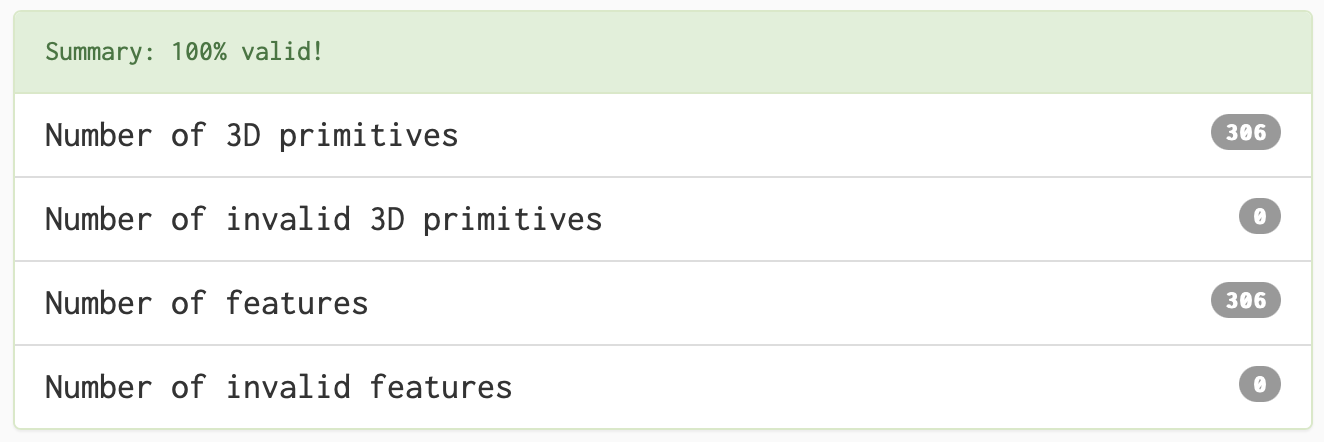

<sup>* *your model conforms to the ISO 19107 standard [connecting and planar surfaces, correct orientation of the surfaces and watertight volumes]*

<div class="alert alert-block alert-warning"><b>NOW</b><br><br>


***To understand the value and usefulness of a 3D City Model***; parse the result of this Notebook through [CityJSONspatialDataScience.ipynb](https://github.com/AdrianKriger/osm_LoD1_3DCityModel/blob/main/village_campus/CityJSONspatialDataScience.ipynb) to workthrough an example of:  
- population estimation and
- a calculation of [Building Volume per Capita]((https://www.researchgate.net/publication/343185735_Building_Volume_Per_Capita_BVPC_A_Spatially_Explicit_Measure_of_Inequality_Relevant_to_the_SDGs)
</div>

***As always; you are welcome to raise an issue. I depend on you to help me improve.***